### Data Ingestion (1)

- Data ingestion from ACRA, MasterDB and SSIC mapping, this data will be merged and filter with selected industry to get the specific company havent been researched by MR.

In [122]:
import os
import requests
import aiohttp
import asyncio
import nest_asyncio
import pandas as pd
import time
import scrapy
from scrapy_playwright.page import PageMethod
from bs4 import BeautifulSoup
import nest_asyncio
import glob
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process
import re


### Getting Master DB via Google API

In [123]:
# --- OPTIMIZED: Handle timeouts, fetch with retries, and increase timeout limits ---

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.auth.transport.requests import AuthorizedSession
import google.auth.transport.requests
import os
import pandas as pd
import re
import socket
import time

sheet_id = '1ipwIl7fciIlddvOUqGLpNlVQufw7Xd26Qa-YuJcx-xE'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

SERVICE_ACCOUNT_FILE = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "credentials.json")
if not os.path.exists(SERVICE_ACCOUNT_FILE):
    raise FileNotFoundError(
        f"Service account file not found at '{SERVICE_ACCOUNT_FILE}'. "
        "Set GOOGLE_APPLICATION_CREDENTIALS to the full path, or place credentials.json next to this notebook."
    )

# --- OPTIMIZATION: Configure credentials and build service with increased timeout ---
credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# Build service - the timeout is configured at the request level
service = build('sheets', 'v4', credentials=credentials, cache_discovery=False)
sheet = service.spreadsheets()

range_a1 = "'MASTER DATABASE 2025 Template'!A:ZZ"

# --- OPTIMIZATION: Fetch with retry logic and increased timeout ---
def fetch_sheet_data_with_retry(sheet_service, spreadsheet_id, range_name, max_retries=3):
    """Fetch sheet data with exponential backoff retry logic."""
    
    # Increase socket timeout globally for this operation
    old_timeout = socket.getdefaulttimeout()
    socket.setdefaulttimeout(300)  # 5 minutes
    
    try:
        for attempt in range(max_retries):
            try:
                print(f"Fetching data from Google Sheets (attempt {attempt + 1}/{max_retries})...")
                
                # Execute the request
                result = sheet_service.values().get(
                    spreadsheetId=spreadsheet_id,
                    range=range_name
                ).execute()
                
                print("✓ Data fetched successfully!")
                return result
                
            except (TimeoutError, socket.timeout, OSError, ConnectionError) as e:
                wait_time = (2 ** attempt) * 2  # Exponential backoff: 2s, 4s, 8s
                print(f"⚠ Timeout error on attempt {attempt + 1}: {type(e).__name__}")
                if attempt < max_retries - 1:
                    print(f"Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    print("✗ Max retries reached.")
                    print("\nTroubleshooting suggestions:")
                    print("1. Check your internet connection")
                    print("2. The sheet might be too large - consider splitting the range")
                    print("3. Try again later if Google Sheets API is experiencing issues")
                    print("4. Consider fetching only required columns instead of A:ZZ")
                    raise
            except HttpError as e:
                print(f"✗ HTTP Error: {e}")
                raise
            except Exception as e:
                print(f"✗ Unexpected error: {type(e).__name__}: {e}")
                raise
    finally:
        # Restore original timeout
        socket.setdefaulttimeout(old_timeout)

# Fetch data with retry mechanism
result = fetch_sheet_data_with_retry(sheet, sheet_id, range_a1)

# --- CLEAN: safe extraction ---
values = result.get('values', [])

if values:
    header = values[0]
    data_rows = values[1:]

    max_len = max([len(header)] + [len(r) for r in data_rows]) if data_rows else len(header)

    if len(header) < max_len:
        header = header + [f'col_{i+1}' for i in range(len(header), max_len)]

    normalized_rows = [row + [''] * (max_len - len(row)) for row in data_rows]

    Master_DB_df = pd.DataFrame(normalized_rows, columns=header)
    print(f"Successfully loaded {len(Master_DB_df)} rows and {len(Master_DB_df.columns)} columns")
else:
    Master_DB_df = pd.DataFrame()
    print("No data found in the sheet")

# ---------------- CLEANING FUNCTIONS ----------------

def clean_ssic_code(value):
    if pd.isna(value) or value == '':
        return None
    try:
        cleaned = re.sub(r"[^0-9]", "", str(value).strip())
        return int(cleaned) if cleaned else None
    except (ValueError, TypeError):
        return None

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = [
        re.sub(r"_+", "_", re.sub(r"[^A-Z0-9]", "_", col.upper().strip())).strip("_")
        for col in df.columns
    ]
    df.columns = new_cols
    return df

# ---------------- PROCESS MASTER DB ----------------

columns_to_keep = [
    "Company Registration Number (UEN)",
    "ACRA REGISTERED NAME",
    "Brand/Deal Name/Business Name",
    "Primary SSIC Code",
    "PIC NAME 1 Contact Number",
    "PIC 1 email address",
    "Website URL",
    "Parent Industry Type",
    "Sub Industry"
]

existing_cols = [c for c in columns_to_keep if c in Master_DB_df.columns]
if not existing_cols:
    raise ValueError("None of the required columns found in the dataframe")

master_db_df = Master_DB_df[existing_cols].copy()
master_db_df = standardize_columns(master_db_df)

uen_cols = [c for c in master_db_df.columns if "UEN" in c]
if not uen_cols:
    raise ValueError("UEN column not found after standardization")

uen_col = uen_cols[0]

master_db_df["UEN"] = (
    master_db_df[uen_col].astype(str).str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)
)
master_db_df["UEN"] = master_db_df["UEN"].replace(['', 'NAN', 'NONE'], None)
master_db_df = master_db_df.drop(columns=[uen_col])

rename_map = {
    "BRAND_DEAL_NAME_BUSINESS_NAME": "BRAND_NAME",
    "PRIMARY_SSIC_CODE": "SSIC_CODE",
}

master_db_df = master_db_df.rename(columns={k: v for k, v in rename_map.items() if k in master_db_df.columns})

for col in ["ACRA_REGISTERED_NAME", "BRAND_NAME"]:
    if col in master_db_df.columns:
        master_db_df[col] = (
            master_db_df[col].astype(str).str.strip().str.upper().replace(['', 'NAN', 'NONE'], None)
        )

if "SSIC_CODE" in master_db_df.columns:
    master_db_df["SSIC_CODE"] = master_db_df["SSIC_CODE"].apply(clean_ssic_code)

required_cols = ["UEN", "ACRA_REGISTERED_NAME", "BRAND_NAME", "SSIC_CODE"]
available_cols = [c for c in required_cols if c in master_db_df.columns]
master_db_df = master_db_df[available_cols].copy()

master_db_df = master_db_df[
    master_db_df["UEN"].notna() & (master_db_df["UEN"].astype(str).str.strip() != "")
]

print(f"Final dataset: {len(master_db_df)} rows, {len(master_db_df.columns)} columns")
master_db_df

Fetching data from Google Sheets (attempt 1/3)...
⚠ Timeout error on attempt 1: TimeoutError
Retrying in 2 seconds...
Fetching data from Google Sheets (attempt 2/3)...
✓ Data fetched successfully!
Successfully loaded 13968 rows and 63 columns
Final dataset: 13243 rows, 4 columns


,UEN,ACRA_REGISTERED_NAME,BRAND_NAME,SSIC_CODE
0,04799400B,AIK BEE TEXTILE CO,AIK BEE TEXTILE CO,46411.0
1,03376200K,SERANGOON GARDEN CLINIC AND DISPENSARY,GARDEN CLINIC,550263.0
2,06239600E,SALON DE BENZIMEN,SALON DE BENZIMEN,96021.0
3,06952000C,SU LAN LADIES FASHION,SU LAN LADIES FASHION,14103.0
4,10381600C,SIN HAI PRINTING SERVICE,SIN HAI PRINTING SERVICE,18113.0
...,...,...,...,...
13963,202306640R,MISTER MOBILE POTONG PASIR PTE. LTD.,MISTER MOBILE (POTONG PASIR),47411.0
13964,202103010N,MISTER MOBILE JURONG PTE. LTD.,MISTER MOBILE (JURONG),47411.0
13965,201734006N,MISTER MOBILE HOUGANG PTE. LTD.,MISTER MOBILE (HOUGANG),95120.0
13966,202210879W,MISTER MOBILE CHINATOWN PTE. LTD.,MISTER MOBILE (CHINATOWN),47411.0


### Getting ACRA Data (Filter by Live, Live Company only & non relevant ssic code)
- last downloaded oct 25

In [124]:

folder_path = "Acra_Data"

# Get all CSV file paths inside the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine all CSVs
# Using low_memory=False to avoid DtypeWarning for mixed types
df = pd.concat((pd.read_csv(f, low_memory=False) for f in csv_files), ignore_index=True)


df.columns = df.columns.str.upper()


acra_data = df[[
    "UEN",
    "ENTITY_NAME",
    "BUSINESS_CONSTITUTION_DESCRIPTION",
    "ENTITY_TYPE_DESCRIPTION",
    "ENTITY_STATUS_DESCRIPTION",
    "REGISTRATION_INCORPORATION_DATE",
    "PRIMARY_SSIC_CODE",
    "SECONDARY_SSIC_CODE",
    "STREET_NAME",
    "POSTAL_CODE"
]].copy()

# Convert to proper data types
acra_data['UEN'] = acra_data['UEN'].astype('string')
acra_data['ENTITY_NAME'] = acra_data['ENTITY_NAME'].astype('string')
acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'] = acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'].astype('string')
acra_data['ENTITY_TYPE_DESCRIPTION'] = acra_data['ENTITY_TYPE_DESCRIPTION'].astype('string')
acra_data['ENTITY_STATUS_DESCRIPTION'] = acra_data['ENTITY_STATUS_DESCRIPTION'].astype('string')
acra_data['REGISTRATION_INCORPORATION_DATE'] = pd.to_datetime(acra_data['REGISTRATION_INCORPORATION_DATE'], errors='coerce')

# Clean string columns — trim, remove extra spaces, uppercase
for col in [
    'UEN',
    'ENTITY_NAME',
    'BUSINESS_CONSTITUTION_DESCRIPTION',
    'ENTITY_TYPE_DESCRIPTION',
    'ENTITY_STATUS_DESCRIPTION',
    'STREET_NAME',
    'POSTAL_CODE'
]:
    acra_data[col] = (
        acra_data[col]
        .fillna('')
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.upper()
    )

# Replace placeholders with NaN for standardization
acra_data.replace(['NA', 'N/A', '-', ''], np.nan, inplace=True)

# Convert registration date to dd-mm-yyyy string (optional)
acra_data['REGISTRATION_INCORPORATION_DATE'] = acra_data['REGISTRATION_INCORPORATION_DATE'].dt.strftime('%d-%m-%Y')

# Filter only live entities (LIVE COMPANY or LIVE)
acra_data = acra_data[
    acra_data['ENTITY_STATUS_DESCRIPTION'].isin(['LIVE COMPANY', 'LIVE'])
].reset_index(drop=True)

# Exclude specific PRIMARY_SSIC_CODE values (supposedly the data would be 600k plus but when we exclude this would lessen)
exclude_codes = [
    46900, 47719, 47749, 47539, 47536, 56123,
    10711, 10712, 10719, 10732, 10733, 93209
]

acra_data = acra_data[~acra_data['PRIMARY_SSIC_CODE'].isin(exclude_codes)].reset_index(drop=True)

In [125]:
acra_data

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623
...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,na,KELANTAN LANE,200031
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,46900,YISHUN INDUSTRIAL STREET 1,768161
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,79101,JALAN BAHAGIA,320034


### Getting SSIC Industry code

In [126]:
# --- CONFIG ---
file_path = "./SSIC_Code/mapped_ssic_code.xlsx"

# --- LOAD DATA ---
mapped_ssic_code = pd.read_excel(file_path)

# --- STANDARDIZE COLUMN NAMES ---  
# Uppercase, strip spaces, replace spaces with underscores
mapped_ssic_code.columns = (
    mapped_ssic_code.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

# --- KEEP ONLY DESIRED COLUMNS ---
columns_to_keep = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "SSIC_CODES", "DESCRIPTION"]
mapped_ssic_code = mapped_ssic_code[columns_to_keep].copy()

# --- CLEAN SSIC_CODES COLUMN ---
mapped_ssic_code["SSIC_CODES"] = (
    pd.to_numeric(mapped_ssic_code["SSIC_CODES"], errors="coerce")  # safely convert to numeric
    .fillna(0)
    .astype(int)
)

# --- CLEAN TEXT COLUMNS ---
text_cols = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "DESCRIPTION"]
mapped_ssic_code[text_cols] = mapped_ssic_code[text_cols].apply(
    lambda col: col.astype(str).str.strip().str.title()
)

# --- REMOVE DUPLICATES & RESET INDEX ---
mapped_ssic_code = mapped_ssic_code.drop_duplicates().reset_index(drop=True)

mapped_ssic_code.head()


,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,SSIC_CODES,DESCRIPTION
0,Retail,Retail,Fashion & Apparel,47711,Retail Sale Of Clothing For Adults
1,Retail,Retail,Fashion & Apparel,47712,Retail Sale Of Children And Infants' Clothing
2,Retail,Retail,Fashion & Apparel,47715,Retail Sale Of Sewing And Clothing Accessories
3,Retail,Retail,Fashion & Apparel,47719,"Retail Sale Of Clothing, Footwear And Leather ..."
4,Retail,Retail,Fashion & Apparel,47510,Retail Sale Of Textiles


### Merge ACRA data with SSIC code

In [127]:
# Convert PRIMARY_SSIC_CODE to int
acra_data["PRIMARY_SSIC_CODE"] = (
    pd.to_numeric(acra_data["PRIMARY_SSIC_CODE"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Merge based on SSIC code
acra_data_filtered = acra_data.merge(
    mapped_ssic_code,
    how="left",
    left_on="PRIMARY_SSIC_CODE",
    right_on="SSIC_CODES"
)

# Optional: drop the duplicate 'SSIC CODES' column (keep only PRIMARY_SSIC_CODE)
acra_data_filtered = acra_data_filtered.drop(columns=["SSIC_CODES"], errors="ignore")


### FIlter Acra data with Master DB to get list of companies havent been researched  by MR

In [128]:

# Ensure both UEN columns are strings for accurate matching
acra_data_filtered['UEN'] = acra_data_filtered['UEN'].astype(str).str.strip().str.upper()
master_db_df['UEN'] = master_db_df['UEN'].astype(str).str.strip().str.upper()

# Filter out rows in acra_data_filtered whose UEN is already in master_db_df
acra_data_filtered = acra_data_filtered[~acra_data_filtered['UEN'].isin(master_db_df['UEN'])]

acra_data_filtered.shape

(529189, 14)

In [129]:
acra_data_filtered

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742,Others,Wholesale Trade,"Food, Beverages & Tobacco","Wholesale Of Livestock, Meat, Poultry, Eggs An..."
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049,Others,Manufacturing,Other Specialised Manufacturing & Distribution,Other Manufacturing Industries N.E.C.
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623,Retail,Retail,Fashion & Apparel,Retail Sale Of Clothing For Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,na,KELANTAN LANE,200031,Services,Services,Hair Salons & Barbershops,Hairdressing Salons/Shops
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,46900,YISHUN INDUSTRIAL STREET 1,768161,Others,Built Environment & Infrastructure,Construction,Renovation Contractors
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969,Others,"Finance, Legal & Real Estate","Legal, Accounting & Consultancy Activities",Management Consultancy Services N.E.C.
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,79101,JALAN BAHAGIA,320034,Others,"Tourism, Agency",Travel Agencies & Tour Operators,Travel Agencies And Tour Operators (Mainly Out...


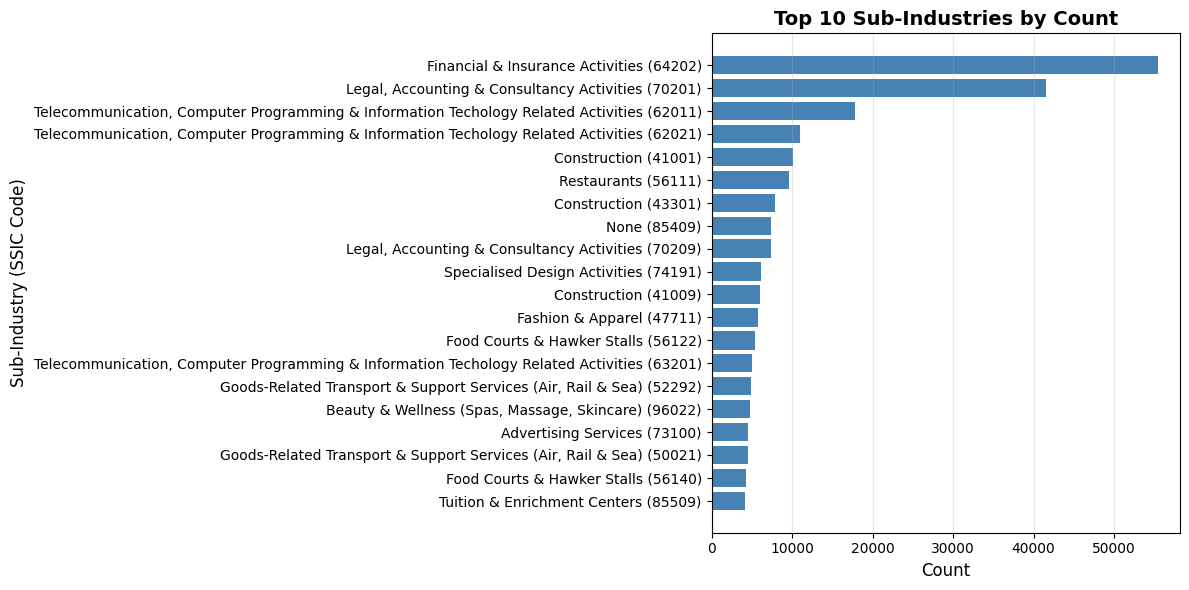


Top 10 SSIC codes with Sub-Industry names:
64202 - Financial & Insurance Activities: 55422
70201 - Legal, Accounting & Consultancy Activities: 41516
62011 - Telecommunication, Computer Programming & Information Techology Related Activities: 17814
62021 - Telecommunication, Computer Programming & Information Techology Related Activities: 11051
41001 - Construction: 10168
56111 - Restaurants: 9603
43301 - Construction: 7825
85409 - None: 7408
70209 - Legal, Accounting & Consultancy Activities: 7350
74191 - Specialised Design Activities: 6097
41009 - Construction: 6030
47711 - Fashion & Apparel: 5724
56122 - Food Courts & Hawker Stalls: 5446
63201 - Telecommunication, Computer Programming & Information Techology Related Activities: 4968
52292 - Goods-Related Transport & Support Services (Air, Rail & Sea): 4905
96022 - Beauty & Wellness (Spas, Massage, Skincare): 4768
73100 - Advertising Services: 4583
50021 - Goods-Related Transport & Support Services (Air, Rail & Sea): 4549
56140 - Food

In [130]:
# Count the values in PRIMARY_SSIC_CODE column and get top 10
ssic_counts = acra_data_filtered['PRIMARY_SSIC_CODE'].value_counts().head(20)

# Create a mapping of SSIC code to SUB_INDUSTRY name
ssic_to_subindustry = acra_data_filtered.groupby('PRIMARY_SSIC_CODE')['SUB_INDUSTRY'].first()

# Create labels with both SSIC code and SUB_INDUSTRY name
labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in ssic_counts.index]

# Sort by count (ascending for horizontal bar chart)
sorted_indices = ssic_counts.sort_values(ascending=True).index
sorted_counts = ssic_counts.sort_values(ascending=True).values
sorted_labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in sorted_indices]

# Create horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_counts, color='steelblue')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Sub-Industry (SSIC Code)', fontsize=12)
plt.title('Top 10 Sub-Industries by Count', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTop 10 SSIC codes with Sub-Industry names:")
for code in ssic_counts.sort_values(ascending=False).index:
    count = ssic_counts[code]
    subindustry = ssic_to_subindustry.get(code, 'Unknown')
    print(f"{code} - {subindustry}: {count}")

### Filter by  Industry

-   after 2020

In [131]:
# Event Organizer
# 75000 (vet), 86204 (Dental), ""
ssic_codes = [
    "74191", 
]

# Convert to datetime
acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] = pd.to_datetime(
    acra_data_filtered["REGISTRATION_INCORPORATION_DATE"],
    dayfirst=True,
    errors="coerce"
)


acra_data_filtered_by_industry = acra_data_filtered[
    (
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live") |
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live company")
    )
    &
    (acra_data_filtered["PRIMARY_SSIC_CODE"].astype(str).isin(ssic_codes))
]


# Optional: filter by date > 2020
acra_data_filtered_by_industry = acra_data_filtered_by_industry[
    (acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] > "2018-01-01") &
    (acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] < "2024-01-01")
]

# Convert date to dd/mm/yyyy format
acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] = (
    acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"].dt.strftime("%d/%m/%Y")
)

print(acra_data_filtered_by_industry.shape)
acra_data_filtered_by_industry

(2384, 14)


,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
15325,201803136Z,AESTHERIOR STUDIO PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,24/01/2018,74191,43301,LORONG 23 GEYLANG,388410,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
15489,201807144R,AI DESIGN COLLECTION PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,01/03/2018,74191,41001,KIM KEAT LANE,328863,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
15504,201807468H,ART LIVING STUDIO PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,02/03/2018,74191,43301,MANDAI LINK,728653,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
15640,201810666Z,ATLANTEAN PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,08/08/2018,74191,na,EMPRESS ROAD,260008,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
15672,201811763W,ARIA HOME PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,06/04/2018,74191,na,BOON LAY WAY,609966,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534790,202313759K,ZHU MENG JIA PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,11/04/2023,74191,43301,CIRCULAR ROAD,049422,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
534828,202319041G,ZAZEEKREATE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,16/05/2023,74191,74113,UBI AVENUE 1,400302,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
534927,202331572N,ZYETA PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,07/08/2023,74191,na,NEIL ROAD,088879,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
536793,53450148J,ZIP DESIGN,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07/05/2022,74191,71112,LOWER DELTA ROAD,169208,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services


### Get the sample data

In [ ]:
# get sample data 
acra_data_filtered_by_industry = acra_data_filtered_by_industry.sample(n=500).reset_index(drop=True)

print(acra_data_filtered_by_industry.shape)
acra_data_filtered_by_industry.tail(10)


(313, 14)


,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
303,53379400E,NIE CREATIONS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,27/03/2018,74191,23994,WOODLANDS INDUSTRIAL PARK E5,757322,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
304,202304846W,HLH INTERIOR AND ENGINEERING PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,10/02/2023,74191,na,UBI AVENUE 1,408937,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
305,53463497D,BURGEON FIRM,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,24/02/2023,74191,na,UPPER SERANGOON VIEW,533880,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
306,53391268K,DFN SERVICES,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,15/12/2018,74191,74193,COMPASSVALE CRESCENT,542287,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
307,202110663G,BISWAS INTERIOR PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,25/03/2021,74191,41009,UBI ROAD 1,408700,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
308,202341093R,HUS ATELIER PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,14/10/2023,74191,43301,WOODLANDS SQUARE,737715,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
309,53463063D,LY INTERIOR DESIGN,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,16/02/2023,74191,43301,PUNGGOL CENTRAL,822163,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
310,202216684E,MIKAE INTERIOR PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,13/05/2022,74191,95240,LOYANG WAY,508775,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
311,53444934D,DISENO ISTUDIO,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,06/01/2022,74191,43301,EDGEDALE PLAINS,820135,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services
312,201912092D,JY INTERIOR DESIGN PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,14/04/2019,74191,na,WOODLANDS INDUSTRIAL PARK E1,757718,Others,"Science, Innovation & Design",Specialised Design Activities,Interior Design Services


In [115]:
print(acra_data_filtered_by_industry.shape)
print(acra_data_filtered_by_industry["UEN"].is_unique)


(313, 14)
True


In [116]:
acra_data_filtered_by_industry.to_parquet("./Staging/Bronze/bronze_data_1.parquet", index=False, engine="fastparquet")

In [117]:
# parquet_path = "./Staging/Silver/Silver_data_2_550.parquet"
# if os.path.exists(parquet_path):
#     RecordOwl_Leads = pd.read_parquet(parquet_path, engine="fastparquet")
#     print(f"Loaded {len(RecordOwl_Leads)} rows from {parquet_path}")
#     print(RecordOwl_Leads.shape)
# else:
#     raise FileNotFoundError(f"Parquet file not found at {parquet_path}")


# # Ensure both UEN columns are strings for accurate matching
# acra_data_filtered['UEN'] = acra_data_filtered['UEN'].astype(str).str.strip().str.upper()
# RecordOwl_Leads['UEN'] = RecordOwl_Leads['UEN'].astype(str).str.strip().str.upper()

# # Filter out rows in acra_data_filtered whose UEN is already in RecordOwl_Leads
# acra_data_filtered = acra_data_filtered[~acra_data_filtered['UEN'].isin(RecordOwl_Leads['UEN'])]

# acra_data_filtered.shape